In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from data_utils import load_and_preprocess_data, train_val_test_split
from rnn_model import RNN
from train import train_model, evaluate_metrics
import warnings
from visualization_utils import plot_predictions, calculate_prediction_metrics, make_predictions,plot_test_predictions_only
import pandas as pd
import numpy as np
from models import GRU
warnings.filterwarnings("ignore")

## RNN

In [ ]:
file_path = "GOOG.csv"
sequence_length = 15
prediction_length = 1
batch_size = 64
hidden_size = 256
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.2
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

X, y, scalers = load_and_preprocess_data(file_path, sequence_length, prediction_length)

X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(X, y)

train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
val_dataset = TensorDataset(torch.tensor(X_val, dtype=torch.float32), torch.tensor(y_val, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

input_size = X.shape[2]  
rnn = RNN(input_size, hidden_size, 1, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(rnn, train_loader, val_loader, criterion, optimizer, num_epochs,"rnn", device)


In [128]:
rnn = torch.load("rnn_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(rnn, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0011
MAE (normalized): 0.0281
MSE (original scale): 26.9201
MAE (original scale): 4.3526

Value Ranges:
Predictions - Min: 87.21, Max: 143.03
Actuals - Min: 83.49, Max: 150.71


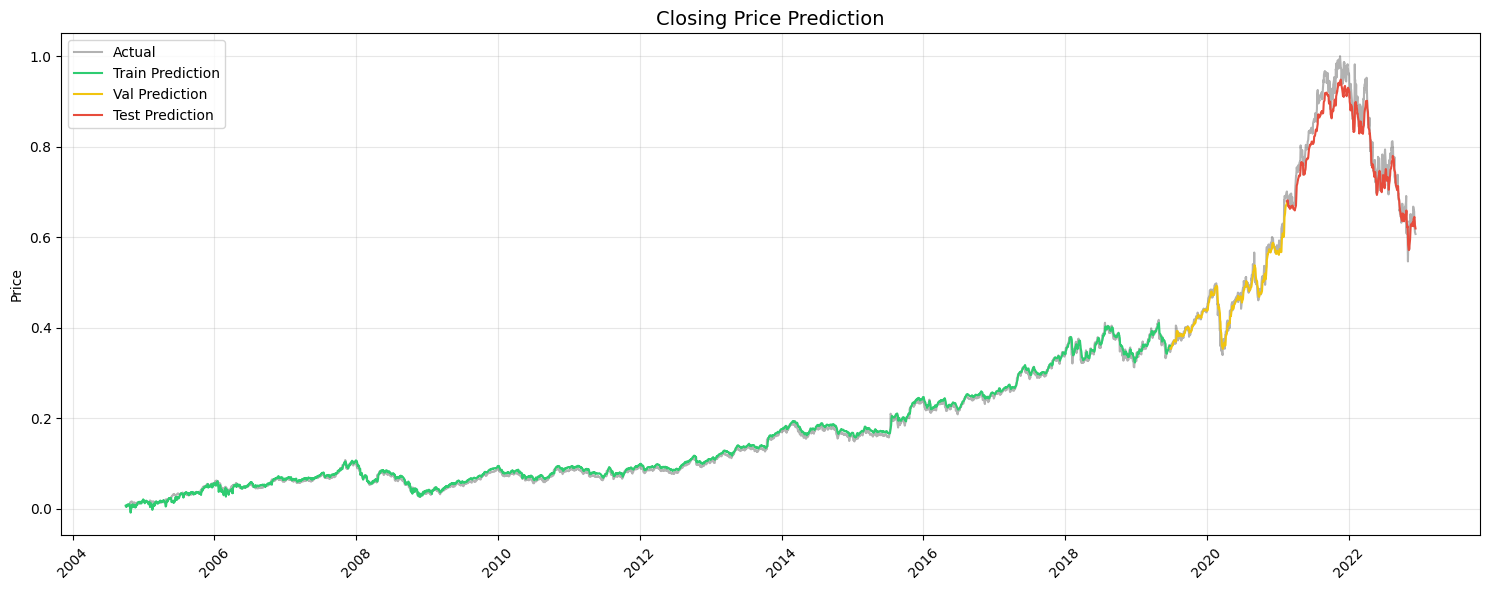

In [129]:
df = pd.read_csv(file_path)
dates = pd.to_datetime(df['Date'], format='%d-%m-%Y')

train_pred, train_actual = make_predictions(rnn, train_loader, device)
val_pred, val_actual = make_predictions(rnn, val_loader, device)
test_pred, test_actual = make_predictions(rnn, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)



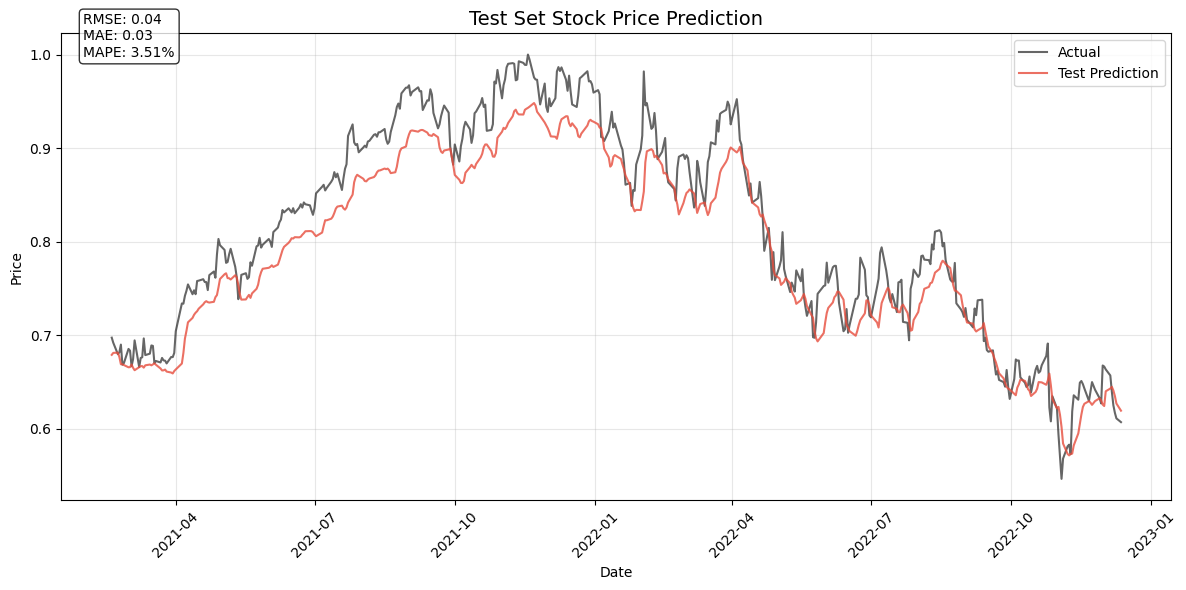


Test Set Metrics:
RMSE: 0.04
MAE: 0.03
MAPE: 3.51%


In [131]:
plot_test_predictions_only(rnn, test_loader, dates, sequence_length, device)

# GRU

In [ ]:
sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 256
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.1
weight_decay = 1e-4

input_size = X.shape[2]  
output_size = 1
gru = GRU(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(gru.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(gru, train_loader, val_loader, criterion, optimizer, num_epochs, "GRU",device)


Epoch [1/30] - Train Loss: 0.0014, Val Loss: 0.0029
Epoch [2/30] - Train Loss: 0.0095, Val Loss: 0.0088
Epoch [3/30] - Train Loss: 0.0034, Val Loss: 0.0017
Epoch [4/30] - Train Loss: 0.0005, Val Loss: 0.0003
Epoch [5/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [6/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [7/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [8/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [9/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [10/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [11/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [13/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [14/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [15/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [16/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [17/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [18/30] - Train Loss: 0.0000, Val Loss: 0.0003
Epoch [19/30] - Train Loss: 0.0000, Val Loss: 0.0003
Ep

In [87]:
gru = torch.load("GRU_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(gru, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0006
MAE (normalized): 0.0205
MSE (original scale): 13.9601
MAE (original scale): 3.0463

Value Ranges:
Predictions - Min: 88.97, Max: 147.68
Actuals - Min: 83.49, Max: 150.71


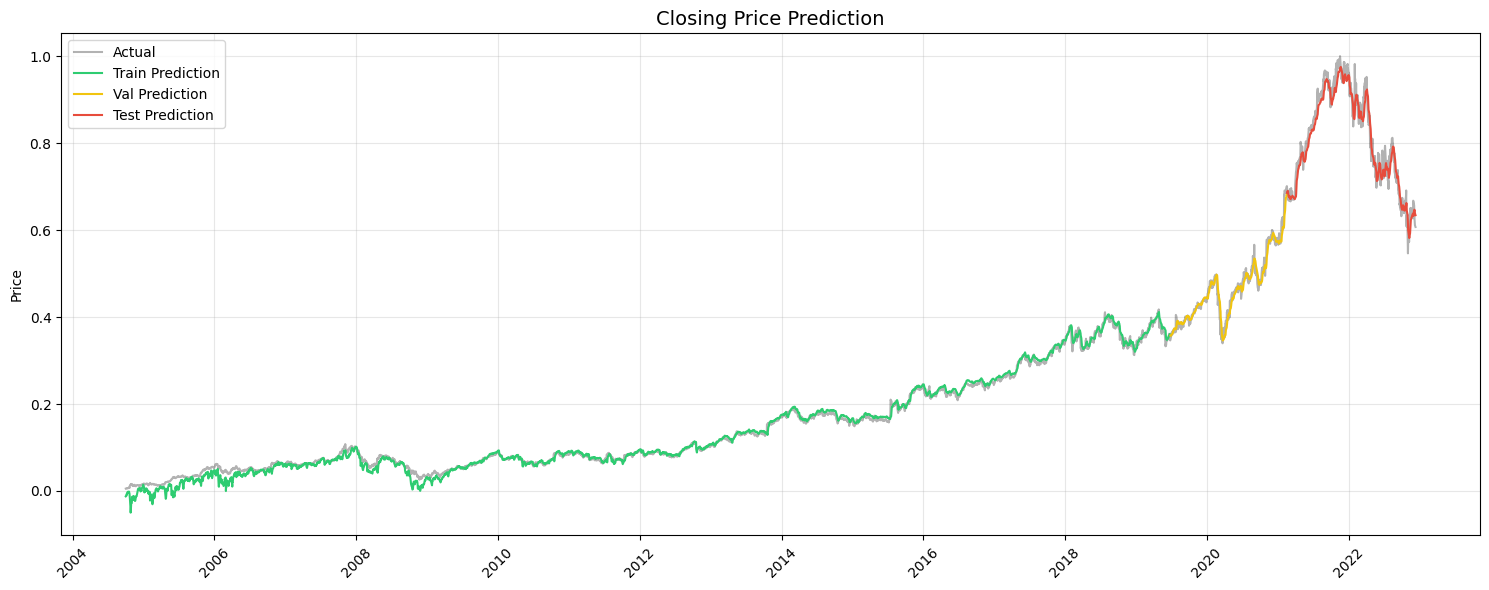


Train Set Metrics:

Val Set Metrics:

Test Set Metrics:


In [ ]:
train_pred, train_actual = make_predictions(gru, train_loader, device)
val_pred, val_actual = make_predictions(gru, val_loader, device)
test_pred, test_actual = make_predictions(gru, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)
    

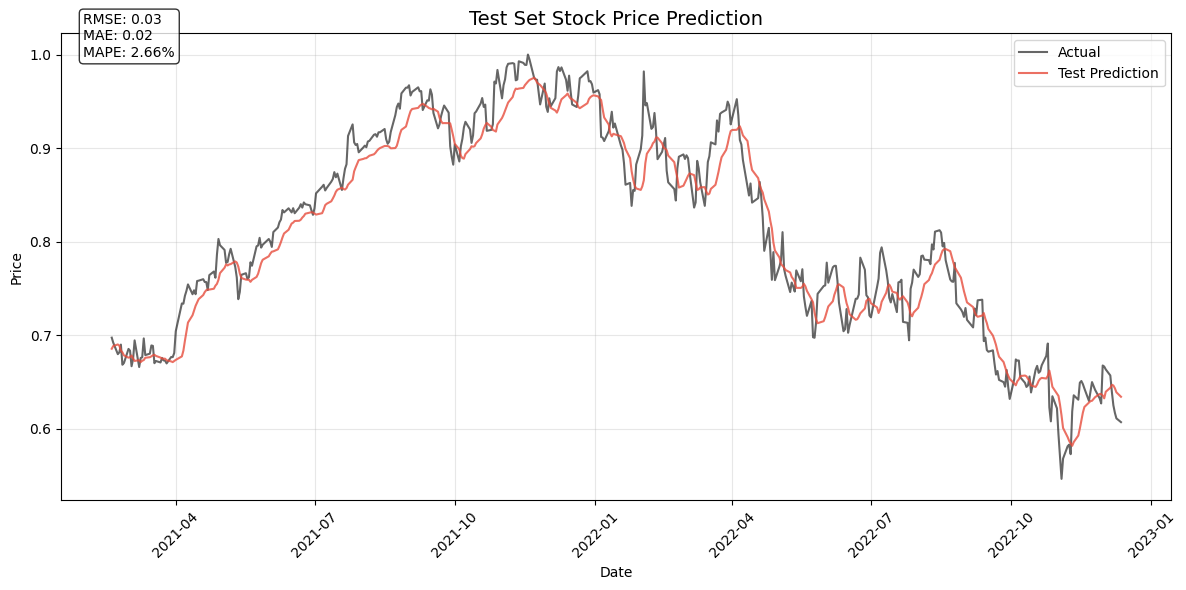


Test Set Metrics:
RMSE: 0.03
MAE: 0.02
MAPE: 2.66%


In [40]:
plot_test_predictions_only(gru, test_loader, dates, sequence_length, device)

## LSTM

In [83]:
from models import LSTM

sequence_length = 30
prediction_length = 1
batch_size = 64
hidden_size = 128
num_layers = 1
num_epochs = 30
learning_rate = 0.0001
dropout_rate = 0.2
weight_decay = 1e-4
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


input_size = X.shape[2]  
output_size = 1
model = LSTM(input_size, hidden_size, output_size, num_layers=num_layers, dropout=dropout_rate).to(device)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, "LSTM",device)


Epoch [1/30] - Train Loss: 0.0075, Val Loss: 0.0539
Epoch [2/30] - Train Loss: 0.0102, Val Loss: 0.0520
Epoch [3/30] - Train Loss: 0.0061, Val Loss: 0.0341
Epoch [4/30] - Train Loss: 0.0043, Val Loss: 0.0173
Epoch [5/30] - Train Loss: 0.0024, Val Loss: 0.0037
Epoch [6/30] - Train Loss: 0.0008, Val Loss: 0.0004
Epoch [7/30] - Train Loss: 0.0001, Val Loss: 0.0005
Epoch [8/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [9/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [10/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [11/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [12/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [13/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [14/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [15/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [16/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [17/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [18/30] - Train Loss: 0.0001, Val Loss: 0.0003
Epoch [19/30] - Train Loss: 0.0001, Val Loss: 0.0004
Ep

In [84]:
lstm = torch.load("LSTM_best_model.pth", map_location=device) 
predictions, actuals, metrics = evaluate_metrics(lstm, test_loader, criterion, scalers, device)


Evaluation Metrics:
MSE (normalized): 0.0008
MAE (normalized): 0.0221
MSE (original scale): 17.9401
MAE (original scale): 3.2308

Value Ranges:
Predictions - Min: 91.96, Max: 148.71
Actuals - Min: 83.49, Max: 150.71


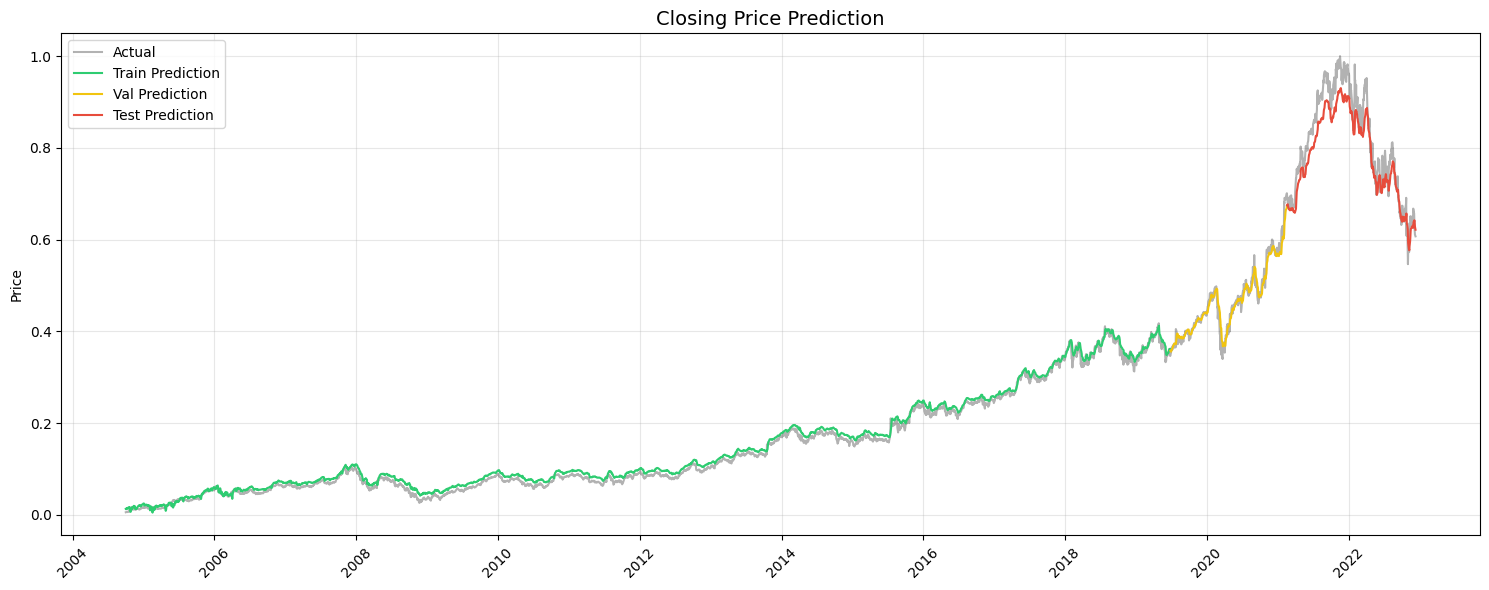


Train Set Metrics:

Val Set Metrics:

Test Set Metrics:


In [ ]:
train_pred, train_actual = make_predictions(lstm, train_loader, device)
val_pred, val_actual = make_predictions(lstm, val_loader, device)
test_pred, test_actual = make_predictions(lstm, test_loader, device)

all_predictions = np.concatenate([train_pred, val_pred, test_pred], axis=0)
all_actuals = np.concatenate([train_actual, val_actual, test_actual], axis=0)

valid_dates = dates[sequence_length:sequence_length+len(all_predictions)]

set_splits = {
    'train': (0, len(train_pred)),
    'val': (len(train_pred), len(train_pred) + len(val_pred)),
    'test': (len(train_pred) + len(val_pred), len(train_pred) + len(val_pred) + len(test_pred))
}

plot_predictions(
    all_predictions, 
    all_actuals, 
    valid_dates, 
    scalers, 
    set_splits, 
    title='Google Stock Price Prediction'
)

    

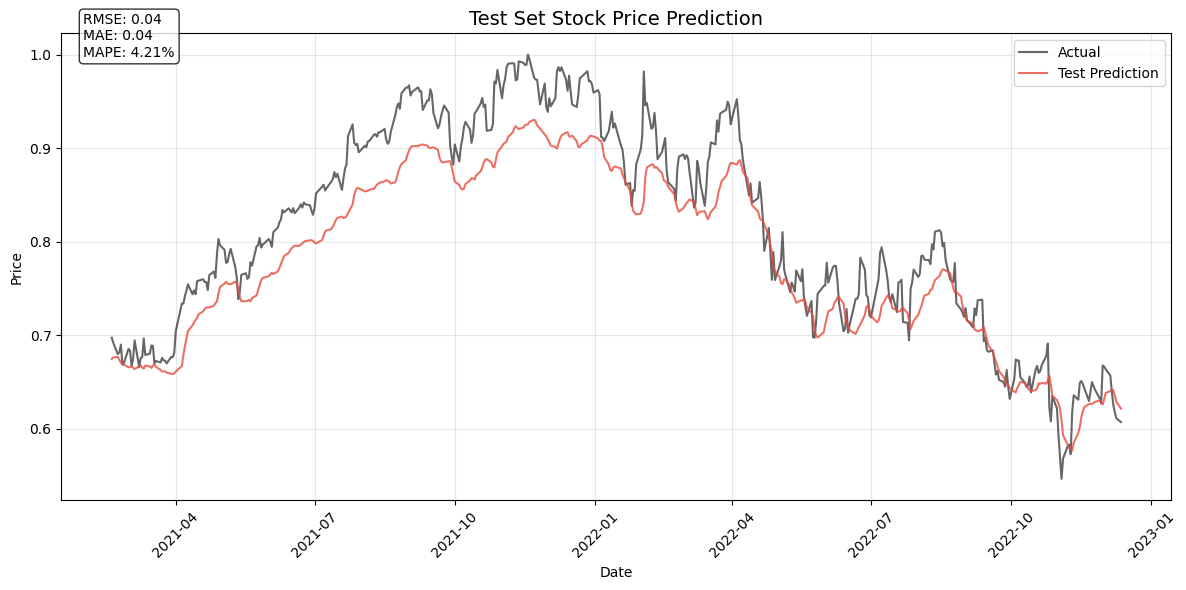


Test Set Metrics:
RMSE: 0.04
MAE: 0.04
MAPE: 4.21%


In [46]:
plot_test_predictions_only(gru, test_loader, dates, sequence_length, device)